## Introduction

In this tutorial, we will explore a novel outlier mining algorithm named isolation forest. We will start with a brief introduction of outlier mining and use real-life cases to explain why outliers are important for us detect and study.
Then, I will walk you through the classes and functions defined in this algorithm in order to learn in detail about how the algorithm works. Then we will explore the existing isolation forest library and learn how to apply it in a specific application case - Credit Card Fraud Detection. Hope you enjoy the journey with me.

We will cover the following topics in this tutorial:
- [Overview of Outlier Mining](#Overview-of-Outlier-Mining)
- [Ensemble Technique: Isolation Forest](#Ensemble-Technique:-Isolation-Forest)
- [Installing the libraries and Exploration](#Installing-the-libraries-and-Exploration)
- [Example Application: Credit Card Fraud Detection with Isolation Forest](#Example-Application:-Credit-Card-Fraud-Detection-with-Isolation-Forest)
- [References](#References)

## Overview of Outlier Mining

What is an outlier? According to Hawkins, an outlier is an observation which deviates so much from the other observations as to arouse suspicions that it was generated by a different mechanism. In short, outliers violates the mechanism that generates the normal data points. 

We want to study these outliers because they are interesting. Here, you don't want to mix outlier with noise. Noise is just random error that you should remove before conducting outlier mining. The anomalies among large datasets excite us to explore more about because they tell us a different story behind the data and equip us with a new perspective to problem solving. 

**Application Scenario: **

> In financial industry, we want to explore the outliers among large volume of credit card transaction data. In this case, outliers are fraudulent transactions, which are generated under a different mechanism than normal transactions. By detecting those outliers real-time, we would be able to take immediate actions to fraud such as locking the suspicious account and make a great improvement to risk management.

> In the gaming world, outlier detection can also play an important role. In an interesting blog ["Detecting Bot Matches in Dota 2"](https://towardsdatascience.com/detecting-bot-matches-in-dota-2-using-isolation-forests-a17c34f60923), the author applies the anomaly detection technique to identifying non-human players in the Game DOTA. This is a very interesting case, and I highly recommmend you to take a look at it if you have time. 

Outlier mining techniques can not only solve industrial challenges but also to detect interesting patterns in daily life. So far, there are many well-developed techniques to solve this problem. In this tutorial, we will be focused on a novel unsupervised learning approach - isolation forest. 

## Ensemble Technique: Isolation Forest

Isolation Forest algorithm was first proposed by Professor Zhou Zhihua from Nanjing University in 2008. [Click here](http://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf) if you are interested in reading the original paper. This novel anomaly detection approach has proved to be very useful in industry, because of its linear time complexity and a low memory requirement which works well with high-dimensional and large-scale datasets.

### Main Idea:

Anomalies are "**few and different**" and they are more possible to be **isolated** from normal points when you randomly partition the space. 

Below is a figure from original paper that illustrates the principle clearly. 

 <img src="isolation.jpg" width=700 height=600/>
 

When you randomly partition a 2-D space with vertical and horizontal lines, the abnormal point x0 is more likely to be isolated than normal point xi. In another word, it takes fewer partitions to isolate the anomalies. It works in the same way in a high dimensional space, where you could use random hyperplane to partition the space.

The **recursive partitioning** process can also be represented as a **binary tree**. The path length from the root node to the current node is the number of partitions required to isolate this node. In the figure above, the path length of point d is only 1, indicating that this point is easily isolated and therefore have a higher anomaly score.
 
 <img src="binary.jpg" width=700 height=600/>
 
 
Isolation Forest constructed a collection of such random trees, and use the **average path length** as the **measure of outlierness**. 

As you can see from the figure below, as the number of random trees grows, the average path length of both xi and x0 converge to a constant value. The outlier x0 is therefore greatly distinguished from xi in this algorithm.

 <img src="avg_path_converge.jpg" width=500 height=400/>
 
 **Sub-sampling** is the key idea when constructing the trees. In Isolation Forest, every time we construct a tree, we would only use a sub-sample of the whole training set. 
 
You might wonder why don't we just use all the training set. Let's take a look at the following training set and you will find out why.  

 <img src="sub_sampling.jpg" width=500 height=400/>

From the figure, you see that in the original sample, the density of red points (outlier) can be very high. Even though outliers are clearly distinguished from the blue points (normal), it is hard to isolate each individual instance, because the average path length calculated for these outlier points within a dense cluster can be as high as normal points.

If you try to sub-sample the training set and generate samples like the figure on the right, it would be much easier to isolate the outliers. That's why we should use sub-sampling when building isolation forest.

### Implementation
Now let's take a look at how to implement Isolation Forest from scratch.

It can be divided into two stages：
> **Training Stage**: building isolation trees with sub-samples of training set

> **Testing Stage**: feed test instance into isolation trees to get anomaly score

#### Training Stage
During training stage, we sub-sample the training set and construct trees to form the iforest.

There are two input parameters in iForest function:
> **number of trees**: Default 100. Empirically, the average path length would converge well before 100 trees are constructed.

> **sub-sampling size**: Default 256. Empirically, the detection performance is near optimal at default setting. Moreover, increasing sub-sampling size without significant performance gain will only increase computation cost.

In [1]:
def iForest(X, t, p):
    """X: input data, t: number of trees, p: sub-sampling size"""
    # initialize forest
    forest = []
    
    # set height limit
    height_limit = np.ceil(np.log2(p))

    # construct iTrees
    for i in range(t):
        X_sample = X.sample(p)
        forest.append(iTree(X_sample, 0, height_limit))
    
    return forest

In [2]:
# define class for exNode (the node where you stop growing the tree further)
class exNode:
    def _init_(self, size):
        self.size = size

# define class for inNode (the node where you keep growing the tree further)
class inNode:
    def _init_(self, Left, Right, SplitAtt, SplitValue):
        self.Left = Left
        self.Right = Right
        self.SplitAtt = SplitAtt
        self.SplitValue = SplitValue

def iTree(X, e, l):
    """X: input data, e: current tree height, l: height limit"""
    # if current tree height exceeds the limit, or the sample size is no more than 1, then exit
    if e >= l or len(X)<=1:
        return exNode(len(X))
    else:
        # let Q be a list of attributes in X
        Q = X.columns
        # let q be a randomly selected attribute from Q
        q = np.random.choice(Q)
        # let p be a randomly selected split point from max and min values of attributes q in X
        p = np.random.uniform(np.min(X[q]), np.max(X[q]))
        
        # filter sample to left and right child node
        X_left = X[X[q]<p]
        X_right = X[X[q]>=p]
        
        # recursively build left/right child nodes
        return inNode(Left=iTree(X_left, e+1, l), 
                      Right=iTree(X_right, e+1, l),
                      SplitAtt=q,
                      SplitValue=p)

#### Testing Stage

During testing stage, we calculated the expected path length E(h(x)) for each test instance. And then derive the anomaly score.

Anomaly score:
$$s = 2^{-\frac{E(h(x))}{c(n)}}$$
$$c(n) = 2H(n-1) - (2(n - 1)/n)$$

C(n) is the average of h(x) given n, which was used to normalise h(x).

If we want to detect top N anomalies, we just need to use s to sort each test instance and find the top N points.

In [3]:
def PathLength(x, T, e):
    """x: test instance, T: an iTree, e: current path legnth"""
    # return the final path length if T is exNode
    if isinstance(T, exNode):
        return e
    
    # iterate through the tree until the exNode is found
    a = T.splitAtt
    if x[a] < T.splitValue:
        return PathLength(x, T.Left, e+1)
    else:
        return PathLength(x, T.Right, e+1)

## Installing the libraries and Exploration

In this part, we will first install the IsolationForest package from sklearn.ensemble. Then, we will use a generated simple dataset to see how it works. If you are interested in reading some more graphic examples, there is a wonderful user guide from the [sklearn.ensemble](http://scikit-learn.org/stable/auto_examples/covariance/plot_outlier_detection.html#sphx-glr-auto-examples-covariance-plot-outlier-detection-py) you may turn to. 

First, install scikit-learn package using pip or conda:

> $ pip install -U scikit-learn

> $ conda install scikit-learn

Please note that only scikit-learn verison 0.18 and above has the implementation of IsolationForest. You might need to update you scikit-learn package using command as below:
> $ conda update scikit-learn

In [4]:
# install the required packages
from sklearn.ensemble import IsolationForest
import numpy as np
import matplotlib.pyplot as plt

# generate datasets
# generate train and test sample from standard normal distribution
train = np.random.randn(100, 2)
test = np.random.randn(20, 2)
# generate outlier sample from uniform distribution
outlier = np.random.uniform(high=5, low=-5, size=(20, 2))

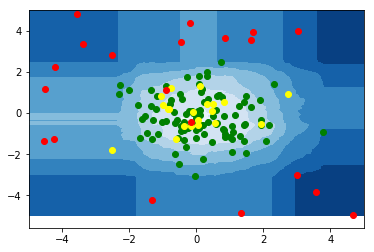

In [5]:
# generate grid points, which will later be used to calculate anomaly score
x_grid = np.linspace(-5, 5, 100)
y_grid = np.linspace(-5, 5, 100)
x, y = np.meshgrid(x_grid, y_grid)

# define isolation forest, and set parameters: max_samples, n_estimators
# you can use default setting here
iforest = IsolationForest(max_samples=100, n_estimators=100, random_state=42)
iforest.fit(train)

# calculate anomaly score for each grid points
anomaly_score = iforest.decision_function(np.c_[x.ravel(), y.ravel()])
anomaly_score = anomaly_score.reshape(100, 100)

plt.contourf(x, y, anomaly_score, cmap=plt.cm.Blues_r)
plt.scatter(train[:, 0], train[:, 1], c="green")
plt.scatter(test[:, 0], test[:, 1], c="yellow")
plt.scatter(outlier[:, 0], outlier[:, 1], c="red")

plt.show()

Note that in sklearn package, the anomaly score returned by decision_function is not the same as the one defined in the original paper. I have seen some applicants misunderstood this, leading to an incorrect conclusion. 

The anomaly score defined in sklearn is that 0.5 - real scores. Therefore, the lower the score is, the more abnormal the instance is.

        # Take the opposite of the scores as bigger is better (here less
        # abnormal) and add 0.5 (this value plays a special role as described
        # in the original paper) to give a sense to scores = 0:
        return 0.5 - scores

## Example Application: Credit Card Fraud Detection with Isolation Forest

Now, we will try to use the real-world datasets [creditcard.csv](https://www.kaggle.com/agpickersgill/credit-card-fraud-detection/data) to test the functionality of Isolation Forest. You can download the data into your folder through this [link](https://drive.google.com/file/d/1l1qYXyXROd8k4Na7UOFApHRBygF0ez7b/view?usp=sharing).

The credit card transaction dataset was originally collected and analyzed during a research collaboration of Wordline and the [Machine Learning Group](http://mlg.ulb.ac.be) of ULB. It contains transaction information from European cardholders in September 2013. Because of confidentiality, we wouldn't be able to see the original features.

### Data Understanding

In [22]:
import io
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score

In [35]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In this dataset, we have 29 numerical variables (V1, ..., V28), which have already been transformed by principle component analysis according to our data source. The feature “Time” represents the seconds elapsed between each transaction and the first transaction. The feature "Amount" represents the amount of each transaction. The last column "Class" indicates whether or not the transaction is fraudulent.

In [8]:
num_transactions = len(df)
num_fraud = sum(df.Class==1)
num_normal = sum(df.Class==0)
pos_fraction = num_fraud/num_transactions
print("Total number of transactions: ", num_transactions)
print("Number of fraudulent transactions: ", num_fraud)
print("Number of normal transactions: ", num_normal)
print("Fraction of positive class: ", pos_fraction)

Total number of transactions:  284807
Number of fraudulent transactions:  492
Number of normal transactions:  284315
Fraction of positive class:  0.001727485630620034


The dataset contains 284,807 transactions, among which 492 transactions are fraudulent. This indicates that we have a highly unbalanced datasets, since the positive class only accounts for 0.172%.

### Data Preprocessing

An important step in every data science problem is to split the dataset into training set and testing test. Here, we will directly use the function from sklearn, and split the datasets into 20% test set and 80% train set.

In [9]:
y = df.Class
X = df.drop("Class", 1)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Implementation and Evaluation
Now, let's implement the algorithm on X_train dataset, and evaluate the outcomes by comparing against the true label.

Notice that in sklearn, there are several input parameters you can manipulate:
- max_samples: sub-sampling size, default value is min(n_samples, 256)
- n_estimators: number of trees, default value is 100
- contamination: the proportion outliers in the dataset, default value is 0.1

In [11]:
from sklearn.ensemble import IsolationForest

# train isolation forest on training set
clf_iforest = IsolationForest(max_samples="auto", n_estimators=100, random_state=42, contamination=0.0017)
clf_iforest.fit(X_train, y_train)

IsolationForest(bootstrap=False, contamination=0.0017, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=1, random_state=42,
        verbose=0)

Now, let's use the trained model to predict the test set. 


Notice that in sklearn, the **predict** function doesn't return 0/1 to identify an outlier, but instead use -1 to suggest an outlier and +1 to suggest an inliner. Therefore, we need to do some transformation in order to compare the predicted result against the true labels. We should also adjust the outcome of **decision_function** to represent the anomaly score described in the original paper.

In [12]:
y_pred = clf_iforest.predict(X_test)
y_pred = -(y_pred -1)/2
y_score = clf_iforest.decision_function(X_test)
y_score = 0.5 - y_score
print("The predicted class: ", y_pred)
print("The predicted anomaly score: ", y_score)
print("The number of predicted positive class in test set: ", sum(y_pred))
print("The number of true positive class in test set: ", sum(y_test))

The predicted class:  [1. 0. 0. ... 0. 0. 0.]
The predicted anomaly score:  [0.69759524 0.43644888 0.38991387 ... 0.43098084 0.37552236 0.4936935 ]
The number of predicted positive class in test set:  94.0
The number of true positive class in test set:  98


Now, let's plot the histogram of the distribution of anomaly scores. You can clearly see from the chart that most data points are centered around 0.4, and only a very small fraction of data points have anomaly score over 0.6. This is what we expect to see because outliers only account for a very small proportion of total dataset.

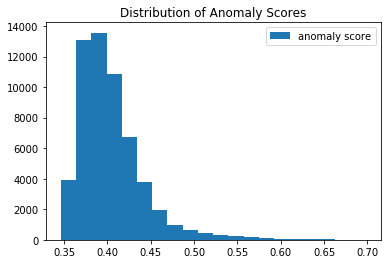

In [13]:
plt.hist(y_score, bins=20, label="anomaly score")
plt.title("Distribution of Anomaly Scores")
plt.legend()
plt.show()

Now, let's compare the predicted outcome against the true labels. and plot the ROC curve.

In [14]:
auc = roc_auc_score(y_test, y_score)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
auprc = average_precision_score(y_test, y_score)
print("AUC score: ", auc)
print("F1 score: ", f1)
print("Accuracy score: ", accuracy)
print("AUPRC score: ", auprc)

AUC score:  0.9532764533781999
F1 score:  0.34375000000000006
Accuracy score:  0.9977879990168884
AUPRC score:  0.30890109363526796


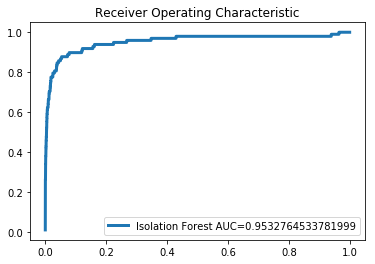

In [15]:
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
auc = np.trapz(tpr, fpr)
plt.plot(fpr, tpr, label="Isolation Forest AUC=" + str(auc), lw=3, color='C0')
plt.title("Receiver Operating Characteristic")
plt.legend()
plt.show()

### Summary
By looking at this application example, I hope you have obtained a basic understanding of how to use isolation forest on real data. Note that there are a couple of other methods you can try to improve the algorithm's performance or extend the work for more precise model.
> **Cross Validation**: tune the hyperparameters including subsampling size and number of trees, and select an optimized model.

> **Kurtosis**: use kurtosis to select features as a refinement over random selection

> **Smote analysis**: eliminate observations with anomaly score less than 0.5 and increase the proposition of the minority class

> **Other supervised/unsupervised algorithm**: try out and compare with other classification algorithms, including Random Forest, SVM and Local Outlier Factor

## References
1. [Case Study: "Detecting Bot Matches in Dota 2"](https://towardsdatascience.com/detecting-bot-matches-in-dota-2-using-isolation-forests-a17c34f60923)
2. [Original Paper: “Isolation forest.”](http://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf)
3. [Kaggle Competition: Credit Crard Fraud Detection](https://www.kaggle.com/agpickersgill/credit-card-fraud-detection/data)
4. [sklearn.ensemble: IsolationForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest)
5. [sklearn User Guide: Novelty and Outlier Detection](http://scikit-learn.org/stable/modules/outlier_detection.html)